## AutoML
- Optuna
    - 모델, 하이퍼파라미터 최적화 
    - Gradient boosting을 이용한 model 중 3가지 SOTA 모델을 Optuna에 입력으로 준다.
        - XGBoost
        - LightGBM
        - CatBoost

In [3]:
# Optuna
import optuna
import hiplot as hip

# Regressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# cross validation
from sklearn.model_selection import cross_val_predict

# visualization
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import PredictionErrorDisplay
import seaborn as sns

import pandas as pd 
import numpy as np

# 평가 지표
import evaluation

# 모델 저장
import pickle
import joblib

In [4]:
df = pd.read_csv('dataframes/mice_selected_df.csv')
features = df.loc[:, (df.columns != 'date') & (df.columns != 'previous interest rate') & (df.columns != 'next interest rate') & (df.columns != 'previous change') & (df.columns != 'present change')
                  & (df.columns != 'CPI')& (df.columns != 'corePCE')& (df.columns != 'PPI')& (df.columns != 'industrial production')]
#target = df['interest rate'].values
target = df['present change'].values

In [5]:
def objective(trial):
    model_name = trial.suggest_categorical('model',['RandomForest'])

    if model_name == 'RandomForest' :
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 150, 250),
            'max_depth' : trial.suggest_int('max_depth', 10, 17),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 20, 50),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
            'random_state' : 42,
            'n_jobs' : -1,
            'criterion' : 'friedman_mse'
        }
        model = RandomForestRegressor(**params)

    y_pred = cross_val_predict(model, features, target, cv=10)
    return evaluation.rmse(y_pred, target)
    
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(max_resource="auto")
    )
study.optimize(objective, n_trials=10)
print(f'Best Model : {study.best_value}, Best Parameters : {study.best_params}')

trial = study.best_trial

print("Best Trial")
print(f"Value : {trial.value}")
print("Params : ")
for key, value in trial.params.items() :
    print(f'{key} : {value}')

[I 2024-10-17 10:04:04,748] A new study created in memory with name: no-name-3970b0d8-d9e5-404f-bfb9-0e69be95aec8
[I 2024-10-17 10:04:06,443] Trial 0 finished with value: 0.47873685487693474 and parameters: {'model': 'RandomForest', 'n_estimators': 195, 'max_depth': 13, 'min_samples_leaf': 49, 'min_samples_split': 9}. Best is trial 0 with value: 0.47873685487693474.
[I 2024-10-17 10:04:08,549] Trial 1 finished with value: 0.47767477462094654 and parameters: {'model': 'RandomForest', 'n_estimators': 247, 'max_depth': 10, 'min_samples_leaf': 36, 'min_samples_split': 9}. Best is trial 1 with value: 0.47767477462094654.
[I 2024-10-17 10:04:10,587] Trial 2 finished with value: 0.477706185951504 and parameters: {'model': 'RandomForest', 'n_estimators': 242, 'max_depth': 16, 'min_samples_leaf': 36, 'min_samples_split': 10}. Best is trial 1 with value: 0.47767477462094654.
[I 2024-10-17 10:04:12,640] Trial 3 finished with value: 0.4779066238720335 and parameters: {'model': 'RandomForest', 'n_e

Best Model : 0.47736697544557394, Best Parameters : {'model': 'RandomForest', 'n_estimators': 194, 'max_depth': 15, 'min_samples_leaf': 33, 'min_samples_split': 9}
Best Trial
Value : 0.47736697544557394
Params : 
model : RandomForest
n_estimators : 194
max_depth : 15
min_samples_leaf : 33
min_samples_split : 9


In [6]:
# best trial 저장 

hyperParameter_path = 'result/autoML/hyperParameters.txt'

try : 

    with open(hyperParameter_path,'r') as f:
        old_text = f.read()
        # 파일을 이어쓰기 모드로 엽니다.
    with open(hyperParameter_path, 'a') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nBest Model : {study.best_value}, Best Parameters : {study.best_params}\n')
        f.write('='*100)


except : 
    with open(hyperParameter_path, 'w') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nBest Model : {study.best_value}, Best Parameters : {study.best_params}\n')
        f.write('='*100)

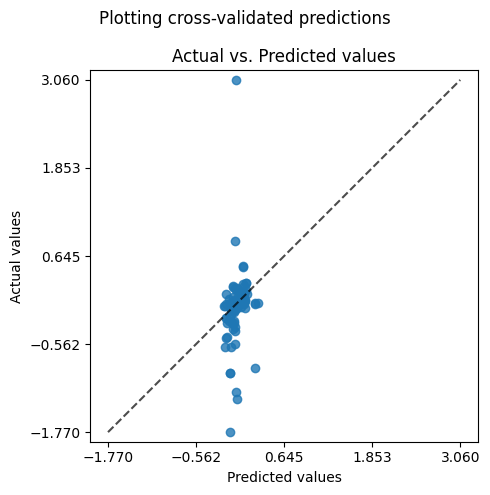

In [7]:
# bset_trial 모델로 결과 확인
# cross_val_pred()로 개별 예측 결과를 추출하고 평가 지표 점수를 계산한다.

# df = pd.read_csv('dataframes/mice_selected_df.csv')
# features = df.loc[:, (df.columns != 'date') & (df.columns != 'previous interest rate') & (df.columns != 'next interest rate') & (df.columns != 'previous change') & (df.columns != 'present change')
#                   & (df.columns != 'CPI')& (df.columns != 'corePCE')& (df.columns != 'PPI')& (df.columns != 'industrial production')]
# #target = df['interest rate'].values
# #target = df['interest rate'].values
# target = df['present change'].values

model_dic = {'RandomForest':RandomForestRegressor}

model = model_dic[trial.params.pop('model')](**trial.params)


y_pred = cross_val_predict(model, features, target, cv=10)


fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax,
    random_state=0,
)
ax.set_title("Actual vs. Predicted values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
title = input('타이틀을 입력하세요')
plt.savefig(f'images/autoML/pred_after_{title}.png')

In [8]:
# 예측 실제 비교 
from random import sample
max = len(target)
idx_list = sorted(sample(range(0,max),5))

file_path = 'result/autoML/autoML_prediction.txt'

try : 

    with open(file_path,'r') as f:
        old_text = f.read()

        # 파일을 이어쓰기 모드로 엽니다.
    with open(file_path, 'a') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nAfter {title}\n')
        for idx in idx_list :
            new_text = f'Prediction : {round(y_pred[idx],2)}, Acutal : {target[idx]}\n'
            f.write(new_text)
        f.write('='*100)
except : 
    with open(file_path, 'w') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nAfter {title}\n')
        for idx in idx_list :
            new_text = f'Prediction : {round(y_pred[idx],2)}, Acutal : {target[idx]}\n'
            f.write(new_text)
        f.write('='*100)

for idx in idx_list :
    print(f'Prediction : {round(y_pred[idx],2)}, Acutal : {target[idx]}')

Prediction : -0.02, Acutal : 0.45
Prediction : -0.11, Acutal : 0.0600000000000005
Prediction : -0.01, Acutal : 0.0499999999999998
Prediction : 0.01, Acutal : -0.04
Prediction : -0.01, Acutal : -0.01


In [9]:
# 평가 지표 점수 계산
import evaluation
from sklearn.metrics import r2_score

file_path = 'result/autoML/autoML_metrics.txt'

MAE, MSE, RMSE, R2 = evaluation.mae(y_pred, target), evaluation.mse(y_pred, target), evaluation.rmse(y_pred, target), r2_score(target, y_pred)

try : 

    with open(file_path,'r') as f:
        old_text = f.read()
        # 파일을 이어쓰기 모드로 엽니다.
    with open(file_path, 'a') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nAfter {title}\n')
        f.write(f'MAE : {MAE}\n')
        f.write(f'MSE : {MSE}\n')
        f.write(f'RMSE : {RMSE}\n')
        f.write(f'R2 : {R2}\n')
        f.write('='*100)


except : 
    with open(file_path, 'w') as f:
        # 수정된 내용을 파일에 이어서 씁니다.
        f.write(f'\nAfter {title}\n')
        f.write(f'MAE : {MAE}\n')
        f.write(f'MSE : {MSE}\n')
        f.write(f'RMSE : {RMSE}\n')
        f.write(f'R2 : {R2}\n')
        f.write('='*100)



print(f'MAE : {MAE}')
print(f'MSE : {MSE}')
print(f'RMSE : {RMSE}')
print(f'R2 : {R2}')

MAE : 0.23234174206412758
MSE : 0.2286834992546393
RMSE : 0.4782086356964283
R2 : 0.009021130510868391


['best_model.pkl']

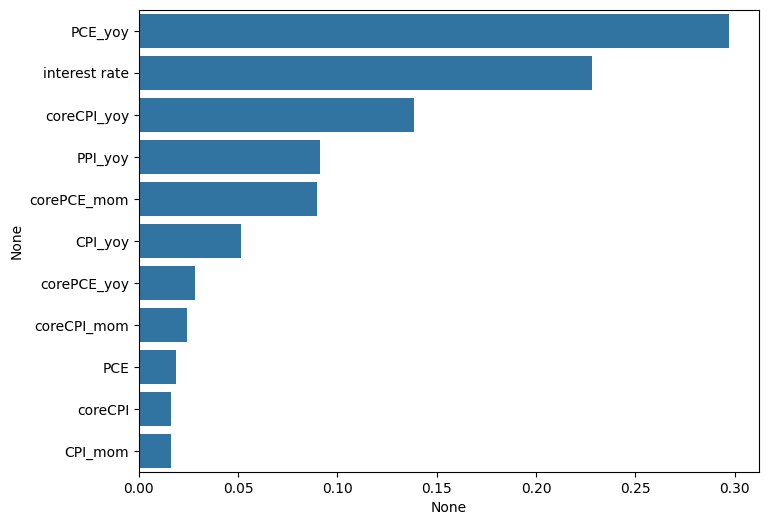

In [10]:
# Feature 중요도 시각화

importances_values = model.fit(X=features, y=target).feature_importances_
importances = pd.Series(importances_values, index=features.columns)
top = importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(8, 6))
sns.barplot(x=top, y=top.index)
plt.savefig(f'images/autoML/feature_importance_{title}.png')

joblib.dump(model,'best_model.pkl')

In [84]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

In [85]:

# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)
